In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import math
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Import required Python modules 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error ,mean_absolute_error, r2_score
# ,mean_absolute_percentage_error

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.gofplots import qqplot as qq

from pylab import rcParams
from pandas.plotting import autocorrelation_plot

In [3]:
# Import python modules for Feed Forward Neural Network
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [4]:
from pmdarima import auto_arima

In [5]:
df = pd.read_csv('amzn.us.csv')

In [6]:
df.describe()

,Open,High,Low,Close,Volume,OpenInt
count,5153.000000,5153.000000,5153.000000,5153.000000,5.153000e+03,5153.0
mean,181.747357,183.880652,179.466684,181.769343,7.837325e+06,0.0
std,239.611052,241.226109,237.638139,239.548391,7.594745e+06,0.0
min,1.410000,1.450000,1.310000,1.400000,0.000000e+00,0.0
25%,35.500000,36.130000,35.000000,35.550000,3.779449e+06,0.0
50%,70.900000,72.750000,69.020000,70.700000,5.902992e+06,0.0
75%,242.850000,245.770000,240.670000,243.880000,8.888949e+06,0.0
max,1126.100000,1135.540000,1124.060000,1132.880000,1.043288e+08,0.0


There are 5153 rows and all columns have values as there are no null values. 
The Volume column has data with large

In [7]:
# Convert data to datatime "Y-M-D"
df['Date'] = pd.to_datetime(df['Date'],format='%Y-%m-%d')

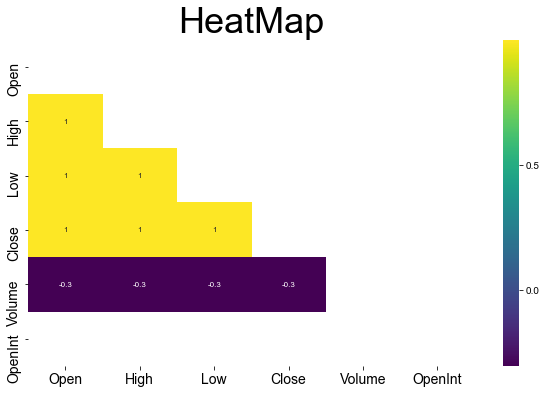

In [8]:
# Plot Heatmap to find the correlation among data columns
fig = plt.figure(figsize=(10,6))
matrix = np.triu(df.corr())
ax = sns.heatmap(df.corr(),annot=True,annot_kws={"size":8},mask=matrix,cmap='viridis')
ax.tick_params(labelsize=14)
sns.set(font_scale=3)
ax.set_title('HeatMap')
plt.style.use('fivethirtyeight')
plt.show()

It can be observed that Volume data has very low correlation with other column data.

In [9]:
df

,Date,Open,High,Low,Close,Volume,OpenInt
0,1997-05-16,1.97,1.98,1.71,1.73,14700000,0
1,1997-05-19,1.76,1.77,1.62,1.71,6106800,0
2,1997-05-20,1.73,1.75,1.64,1.64,5467200,0
3,1997-05-21,1.64,1.65,1.38,1.43,18853200,0
4,1997-05-22,1.44,1.45,1.31,1.40,11776800,0
...,...,...,...,...,...,...,...
5148,2017-11-06,1109.15,1125.41,1108.77,1120.66,3331738,0
5149,2017-11-07,1124.74,1130.60,1117.50,1123.17,2684443,0
5150,2017-11-08,1122.82,1135.54,1119.11,1132.88,2576010,0
5151,2017-11-09,1125.96,1129.62,1115.77,1129.13,3729978,0


In [10]:
dt_vol = df.drop(axis=1,labels=['Open','High','Low','Close','OpenInt'])
col_order = ['Date','Volume']
dt_vol = dt_vol.reindex(columns=col_order)
dt_vol.index = dt_vol['Date']
dt_vol

,Date,Volume
Date,,
1997-05-16,1997-05-16,14700000
1997-05-19,1997-05-19,6106800
1997-05-20,1997-05-20,5467200
1997-05-21,1997-05-21,18853200
1997-05-22,1997-05-22,11776800
...,...,...
2017-11-06,2017-11-06,3331738
2017-11-07,2017-11-07,2684443
2017-11-08,2017-11-08,2576010


In [11]:
# AS the data points are highly volatile on each daily basis, the volume data
# is converted to monthly mean so that there is one record for every month in the year
monthly_mean_vol = dt_vol['Volume'].resample('M').mean()
dt_mvol = monthly_mean_vol.to_frame()
dt_mvol

,Volume
Date,
1997-05-31,9.218040e+06
1997-06-30,2.531600e+06
1997-07-31,4.937018e+06
1997-08-31,1.519371e+06
1997-09-30,5.136286e+06
...,...
2017-07-31,3.925968e+06
2017-08-31,3.353445e+06
2017-09-30,2.952412e+06


In [12]:
dt_mvol['Date'] = dt_mvol.index.copy()
dt_mvol

,Volume,Date
Date,,
1997-05-31,9.218040e+06,1997-05-31
1997-06-30,2.531600e+06,1997-06-30
1997-07-31,4.937018e+06,1997-07-31
1997-08-31,1.519371e+06,1997-08-31
1997-09-30,5.136286e+06,1997-09-30
...,...,...
2017-07-31,3.925968e+06,2017-07-31
2017-08-31,3.353445e+06,2017-08-31
2017-09-30,2.952412e+06,2017-09-30


In [13]:
dt_vol = dt_mvol[['Date','Volume']]
dt_vol

,Date,Volume
Date,,
1997-05-31,1997-05-31,9.218040e+06
1997-06-30,1997-06-30,2.531600e+06
1997-07-31,1997-07-31,4.937018e+06
1997-08-31,1997-08-31,1.519371e+06
1997-09-30,1997-09-30,5.136286e+06
...,...,...
2017-07-31,2017-07-31,3.925968e+06
2017-08-31,2017-08-31,3.353445e+06
2017-09-30,2017-09-30,2.952412e+06


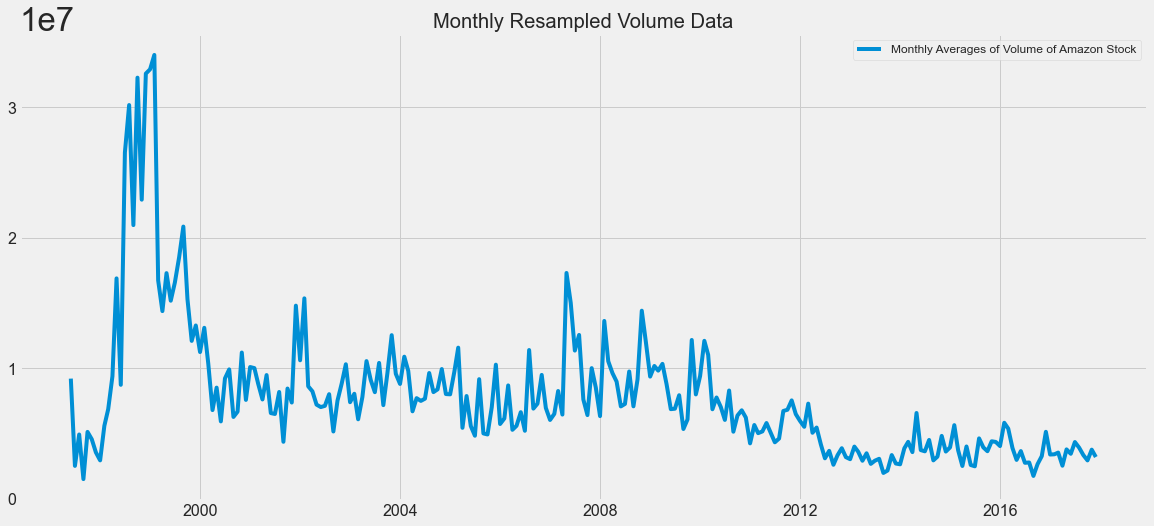

In [14]:
# plotting the resampled monthly data
fig = plt.figure(figsize=(18,8))
ax = fig.add_subplot(1,1,1)
plt.plot(dt_vol['Volume'],label='Monthly Averages of Volume of Amazon Stock')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax.set_title('Monthly Resampled Volume Data')
plt.style.use('fivethirtyeight')
plt.legend(prop={'size': 12})
plt.show()

## Exploratory Data Analysis

(array([0.0e+00, 2.0e-08, 4.0e-08, 6.0e-08, 8.0e-08, 1.0e-07, 1.2e-07,
        1.4e-07]),
 <a list of 8 Text major ticklabel objects>)

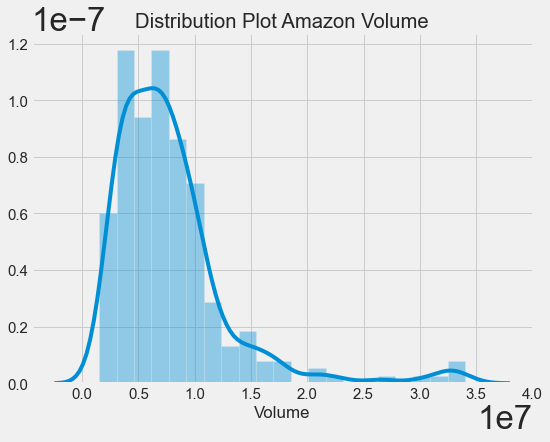

In [15]:
# Check the distribution of Volume data
fig = plt.figure(figsize=(8,6))
sns.distplot(dt_vol['Volume']).set_title("Distribution Plot Amazon Volume")
ax.tick_params(labelsize=10)
sns.set(font_scale=1)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

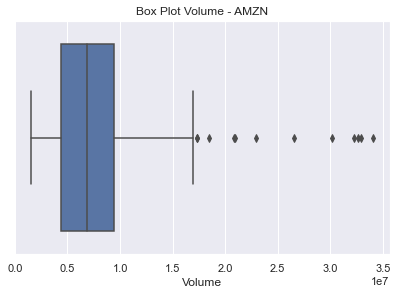

In [16]:
# Box plot of Volume data to view skewness
fig = plt.figure(figsize=(6,4))
sns.boxplot(dt_vol['Volume']).set_title('Box Plot Volume - AMZN')
plt.style.context('fivethirtyeight')

In [17]:
print("Skewness of Volume", dt_vol['Volume'].skew())
print("Kurtosis of Volume", dt_vol['Volume'].kurtosis())

Skewness of Volume 2.506421615520588
Kurtosis of Volume 8.484998848408319


Text(0.5, 1.0, 'QQ Plot Volume Data')

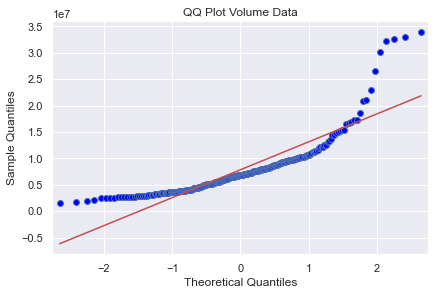

In [18]:
qq_vol_plot = qq(dt_vol['Volume'], line='s')
plt.title('QQ Plot Volume Data')

The QQ plot of volume data shows that both skewness in right and left end of curves

In [19]:
# Compute Month and Year columns from date
dt_vol['Year'] = pd.DatetimeIndex(dt_vol['Date']).year
dt_vol['Month'] = pd.DatetimeIndex(dt_vol['Date']).strftime('%B')

<ipython-input-19-dd7bca8cb280>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dt_vol['Year'] = pd.DatetimeIndex(dt_vol['Date']).year
<ipython-input-19-dd7bca8cb280>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dt_vol['Month'] = pd.DatetimeIndex(dt_vol['Date']).strftime('%B')


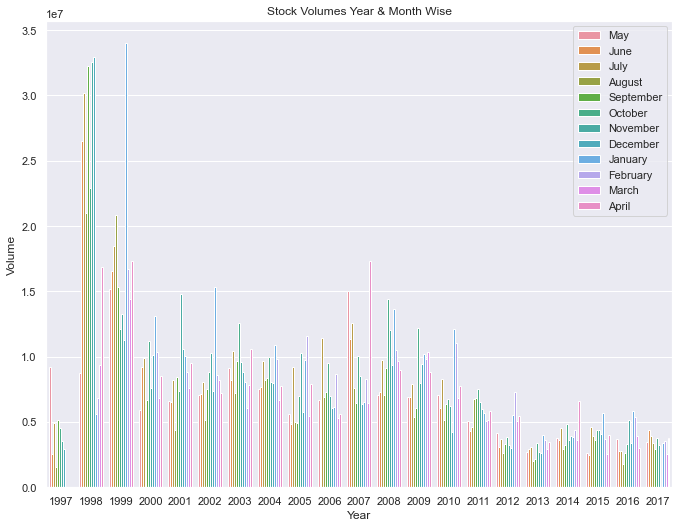

In [20]:
fig, ax = plt.subplots(figsize=(10,8))
palette = sns.color_palette("mako_r", 4)
a = sns.barplot(x="Year", y="Volume",hue = 'Month',data=dt_vol)
a.set_title("Stock Volumes Year & Month Wise",fontsize=12)
plt.legend(loc='upper right')
plt.show()

The plot of monthly volume per year spread over the entire dataset. The volumes of the stock were very high during initial period 1998 and 1999 but gradually decreases year over year.

In [21]:
dt_vol

,Date,Volume,Year,Month
Date,,,,
1997-05-31,1997-05-31,9.218040e+06,1997,May
1997-06-30,1997-06-30,2.531600e+06,1997,June
1997-07-31,1997-07-31,4.937018e+06,1997,July
1997-08-31,1997-08-31,1.519371e+06,1997,August
1997-09-30,1997-09-30,5.136286e+06,1997,September
...,...,...,...,...
2017-07-31,2017-07-31,3.925968e+06,2017,July
2017-08-31,2017-08-31,3.353445e+06,2017,August
2017-09-30,2017-09-30,2.952412e+06,2017,September


## Decomposition of Time Series into Seasonal, Trend and Residuals

In [22]:
# Check the Stationarity of the Time Series
from statsmodels.tsa.stattools import adfuller
adf_result = adfuller(dt_vol['Volume'])

print('ADF p-value: %f' % adf_result[1])
print('Critical Values of ADF Test:')
for kName, value in adf_result[4].items():
	print('\t%s: %.3f' % (kName, value))
 


ADF p-value: 0.095960
Critical Values of ADF Test:
	1%: -3.459
	5%: -2.874
	10%: -2.573


In [23]:
# taking a diff of volume data. After diff,
# the first value is Null. Hence taking from second row as diff_dt[1:]
diff_dt = dt_vol['Volume'].diff()
adf_result = adfuller(diff_dt[1:])

print("After performing Diff once...")
print('ADF p-value : %f' % adf_result[1])
print('Critical Values of ADF Test:')
for kName, value in adf_result[4].items():
	print('\t%s: %.3f' % (kName, value))

After performing Diff once...
ADF p-value : 0.000000
Critical Values of ADF Test:
	1%: -3.458
	5%: -2.874
	10%: -2.573


In [24]:
# taking a diff of volume data. After diff,
# the first value is Null. Hence taking from 
# second row as diff_dt[1:]
diff_dt = dt_vol['Volume'].diff()
adf_result = adfuller(diff_dt[1:])

print("After performing Diff once...")
print('ADF p-value : %f' % adf_result[1])
print('Critical Values of ADF Test:')
for kName, value in adf_result[4].items():
	print('\t%s: %.3f' % (kName, value))

After performing Diff once...
ADF p-value : 0.000000
Critical Values of ADF Test:
	1%: -3.458
	5%: -2.874
	10%: -2.573


The timeseries without change of the data is stationary as p-Value is < 0.05.

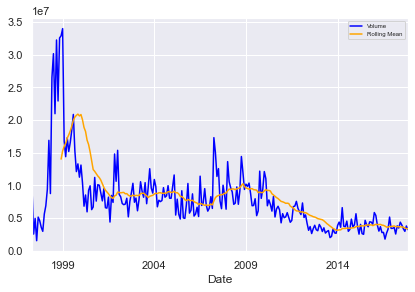

In [25]:
# Plot diff data to check stationarity visually
dt_vol['Volume'].plot(c='blue')
dt_vol['Volume'].rolling(20).mean().plot(label='Rolling Mean',c='orange')
plt.legend(prop={'size': 6})     

Graph shows the series is not stationary as the mean is not always zero . it varies as shown in orange line

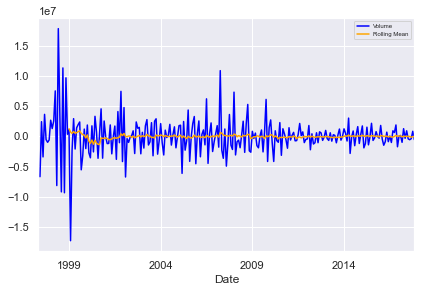

In [26]:
# Plot diff data to check stationarity visually
dt_vol['Volume'].diff().plot(c='blue')
dt_vol['Volume'].diff().rolling(20).mean().plot(label='Rolling Mean',c='orange')
plt.legend(prop={'size': 6})

The plot of diff data confirms that the time series is staionary after taking the difference once. The mean is almost zero as seen from the orange line.

Text(0.5, 0, 'Lags')

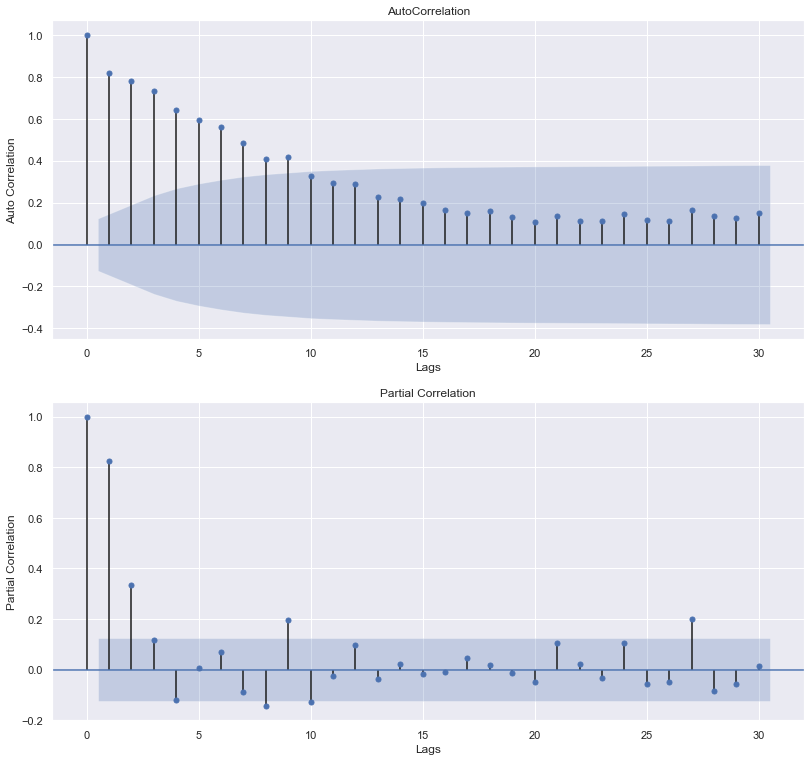

In [27]:
fig,(ax1,ax2) = plt.subplots(2,figsize=(12,12))
acf = plot_acf(dt_vol['Volume'],lags=30,ax=ax1)
ax1.set_title('AutoCorrelation')
acf = plot_pacf(dt_vol['Volume'],lags=30,ax=ax2)
ax2.set_title('Partial Correlation')
ax1.set_ylabel('Auto Correlation')
ax1.set_xlabel('Lags')
ax2.set_ylabel('Partial Correlation')
ax2.set_xlabel('Lags')

In [28]:
# Decomposition of Volume Time series into Trend, Seasonality and Noise manually
# Manually compute trend series for Volume

# Create an empty column for trend
dt_vol['TREND'] = np.nan

for i in range(6,dt_vol['Volume'].size-6):
    dt_vol['TREND'][i] = np.round( dt_vol['Volume'][i - 6] * 1.0 / 24 +
        (   dt_vol['Volume'][i - 5] +
            dt_vol['Volume'][i - 4] +
            dt_vol['Volume'][i - 3] +
            dt_vol['Volume'][i - 2] +
            dt_vol['Volume'][i - 1] +
            dt_vol['Volume'][i] +
            dt_vol['Volume'][i + 1] +
            dt_vol['Volume'][i + 2] +
            dt_vol['Volume'][i + 3] +
            dt_vol['Volume'][i + 4] +
            dt_vol['Volume'][i + 5]
        ) * 1.0 / 12 + dt_vol['Volume'][i + 6] * 1.0 / 24)

<ipython-input-28-a49f83384a9e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dt_vol['TREND'] = np.nan
<ipython-input-28-a49f83384a9e>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dt_vol['TREND'][i] = np.round( dt_vol['Volume'][i - 6] * 1.0 / 24 +
C:\Users\Shi\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3343: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  e

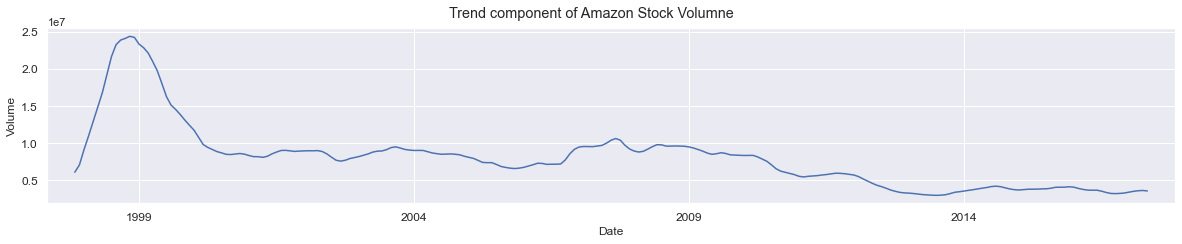

In [29]:
# Plot the trend series
rcParams['figure.figsize'] = 18, 3
fig = plt.figure()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Volume', fontsize=12)
fig.suptitle('Trend component of Amazon Stock Volumne')
dt_vol['TREND'].plot()
plt.show()

In [30]:
dt_vol['SEASONALITY_WITH_NOISE'] = dt_vol['Volume'] / dt_vol['TREND']

<ipython-input-30-1fb14733fa4a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dt_vol['SEASONALITY_WITH_NOISE'] = dt_vol['Volume'] / dt_vol['TREND']


In [31]:
# Compute Seasonality Series without noise
dt_vol['MONTH'] = dt_vol.index.strftime('%m').astype(np.int)

# init month values
avg_seasonal_val = {1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0, 10:0, 11:0, 12:0}
avg_seasonal_val_cnt = {1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0, 10:0, 11:0, 12:0}

# Calculate values and sums
for i in range(0, len(dt_vol['SEASONALITY_WITH_NOISE'])):
  if math.isnan(dt_vol['SEASONALITY_WITH_NOISE'][i]) is False:
    avg_seasonal_val[dt_vol['MONTH'][i]] = \
    avg_seasonal_val[dt_vol['MONTH'][i]] + \
    dt_vol['SEASONALITY_WITH_NOISE'][i]
    avg_seasonal_val_cnt[dt_vol['MONTH'][i]] = \
    avg_seasonal_val_cnt[dt_vol['MONTH'][i]] + 1

# Compute avg value for each month
for i in range(1, 13):
  avg_seasonal_val[i] = avg_seasonal_val[i] / avg_seasonal_val_cnt[i]

# Create the Seasonlity series
dt_vol['SEASONALITY'] = np.nan
 
for i in range(0, dt_vol['SEASONALITY_WITH_NOISE'].size):
  if math.isnan(dt_vol['SEASONALITY_WITH_NOISE'][i]) is False:
    dt_vol['SEASONALITY'][i] = \
    avg_seasonal_val[dt_vol['MONTH'][i]]

<ipython-input-31-75c5e1a1ffef>:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dt_vol['MONTH'] = dt_vol.index.strftime('%m').astype(np.int)
<ipython-input-31-75c5e1a1ffef>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dt_vol['MONTH'] = dt_vol.index.strftime('%m').astype(np.int)
<ipython-input-31-75c5e1

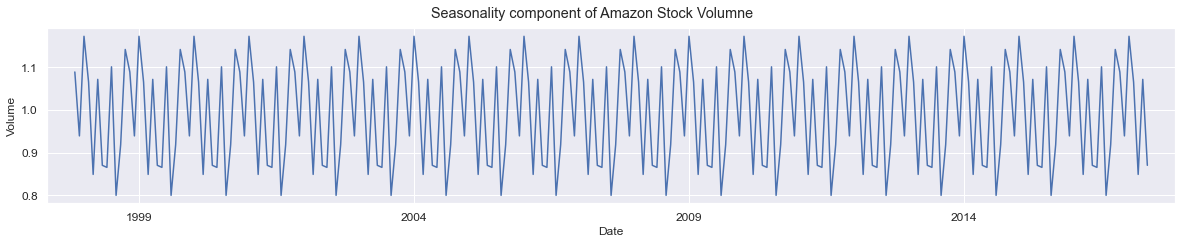

In [32]:
# Plot the Seasonality series
rcParams['figure.figsize'] = 18, 3
fig = plt.figure()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Volume', fontsize=12)
fig.suptitle('Seasonality component of Amazon Stock Volumne')
dt_vol['SEASONALITY'].plot()
plt.show()

<ipython-input-33-7d03b28c3244>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dt_vol['NOISE'] = dt_vol['SEASONALITY_WITH_NOISE']/dt_vol['SEASONALITY']


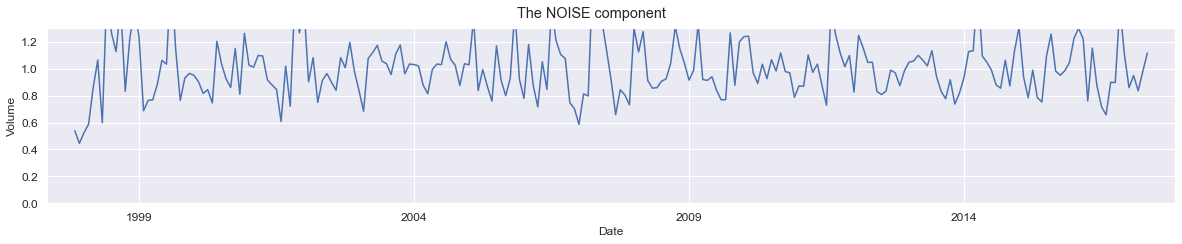

In [33]:
# Compute Noise Series
dt_vol['NOISE'] = dt_vol['SEASONALITY_WITH_NOISE']/dt_vol['SEASONALITY']
 
#plot the Noise component
rcParams['figure.figsize'] = 18, 3
fig = plt.figure()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Volume', fontsize=12)
fig.suptitle('The NOISE component')
plt.ylim(0, 1.3)
dt_vol['NOISE'].plot()
plt.show()

<ipython-input-34-a03b298a91a2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dt_vol["detrended"] = dt_vol["Volume"] - dt_vol["TREND"]


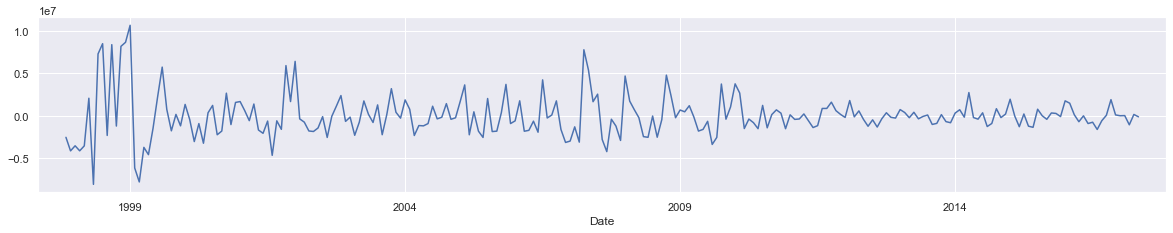

In [34]:
dt_vol["detrended"] = dt_vol["Volume"] - dt_vol["TREND"]
dt_vol["detrended"].plot()

<ipython-input-35-1c491cd43752>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dt_vol["resid"] = dt_vol["detrended"] - dt_vol["SEASONALITY"]


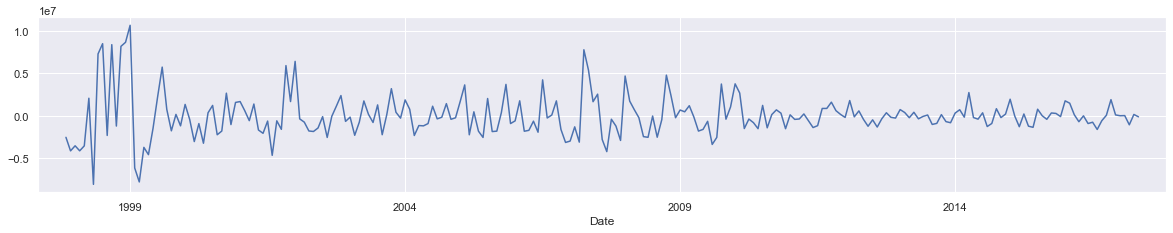

In [35]:
dt_vol["resid"] = dt_vol["detrended"] - dt_vol["SEASONALITY"]
dt_vol["resid"].plot()

<Figure size 1296x216 with 0 Axes>

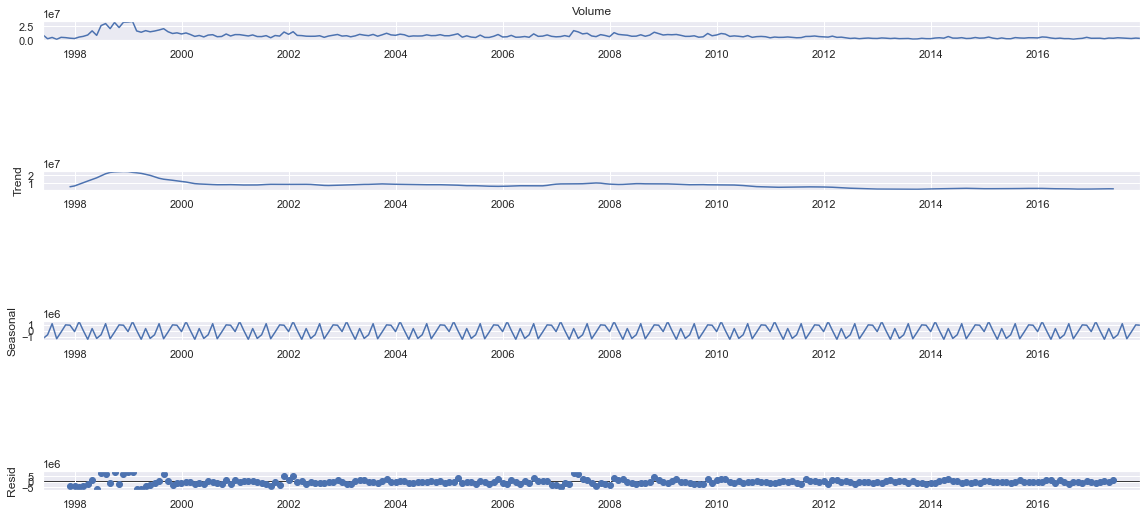

In [36]:
result = seasonal_decompose(dt_vol['Volume'], model='additive')
fig = plt.figure()
fig = result.plot()  
fig.set_size_inches(16, 9)

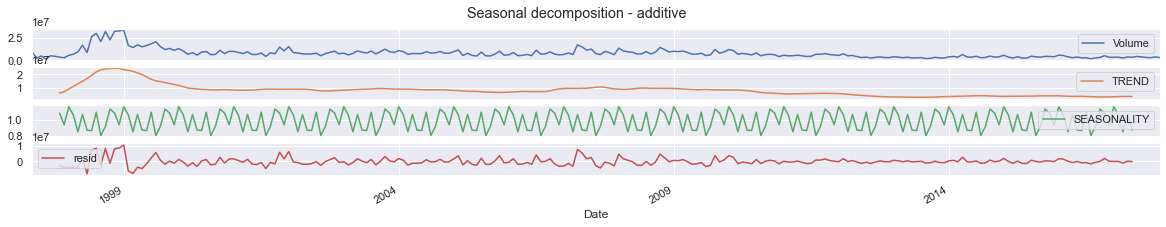

In [37]:
(
    dt_vol.loc[:, ["Volume", "TREND", "SEASONALITY", "resid"]]
    .plot(subplots=True, title="Seasonal decomposition - additive")
);

It can be observed that the Seasonal Decompose function on volume data and manual calculation is pretty similar

In [38]:
dt_vol

,Date,Volume,Year,Month,TREND,SEASONALITY_WITH_NOISE,MONTH,SEASONALITY,NOISE,detrended,resid
Date,,,,,,,,,,,
1997-05-31,1997-05-31,9.218040e+06,1997,May,NaN,NaN,5,NaN,NaN,NaN,NaN
1997-06-30,1997-06-30,2.531600e+06,1997,June,NaN,NaN,6,NaN,NaN,NaN,NaN
1997-07-31,1997-07-31,4.937018e+06,1997,July,NaN,NaN,7,NaN,NaN,NaN,NaN
1997-08-31,1997-08-31,1.519371e+06,1997,August,NaN,NaN,8,NaN,NaN,NaN,NaN
1997-09-30,1997-09-30,5.136286e+06,1997,September,NaN,NaN,9,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2017-07-31,2017-07-31,3.925968e+06,2017,July,NaN,NaN,7,NaN,NaN,NaN,NaN
2017-08-31,2017-08-31,3.353445e+06,2017,August,NaN,NaN,8,NaN,NaN,NaN,NaN
2017-09-30,2017-09-30,2.952412e+06,2017,September,NaN,NaN,9,NaN,NaN,NaN,NaN


Split the volume data into train and test , and test data with last 3 months

In [39]:
sel_data = dt_vol[6:-6].copy()
sel_data

,Date,Volume,Year,Month,TREND,SEASONALITY_WITH_NOISE,MONTH,SEASONALITY,NOISE,detrended,resid
Date,,,,,,,,,,,
1997-11-30,1997-11-30,3.568295e+06,1997,November,6081551.0,0.586741,11,1.089138,0.538720,-2.513256e+06,-2.513257e+06
1997-12-31,1997-12-31,2.953745e+06,1997,December,7062126.0,0.418252,12,0.939182,0.445336,-4.108381e+06,-4.108381e+06
1998-01-31,1998-01-31,5.604000e+06,1998,January,9114239.0,0.614862,1,1.172876,0.524234,-3.510239e+06,-3.510240e+06
1998-02-28,1998-02-28,6.874800e+06,1998,February,10976919.0,0.626296,2,1.065483,0.587805,-4.102119e+06,-4.102120e+06
1998-03-31,1998-03-31,9.400855e+06,1998,March,12918733.0,0.727692,3,0.848850,0.857268,-3.517878e+06,-3.517879e+06
...,...,...,...,...,...,...,...,...,...,...,...
2017-01-31,2017-01-31,3.419104e+06,2017,January,3393711.0,1.007482,1,1.172876,0.858984,2.539255e+04,2.539138e+04
2017-02-28,2017-02-28,3.549722e+06,2017,February,3507210.0,1.012121,2,1.065483,0.949918,4.251174e+04,4.251067e+04
2017-03-31,2017-03-31,2.544442e+06,2017,March,3585691.0,0.709610,3,0.848850,0.835967,-1.041249e+06,-1.041250e+06


In [40]:
df_train = sel_data[:-3].copy()
df_test = sel_data[-3:].copy()

In [41]:
df_train

,Date,Volume,Year,Month,TREND,SEASONALITY_WITH_NOISE,MONTH,SEASONALITY,NOISE,detrended,resid
Date,,,,,,,,,,,
1997-11-30,1997-11-30,3.568295e+06,1997,November,6081551.0,0.586741,11,1.089138,0.538720,-2.513256e+06,-2.513257e+06
1997-12-31,1997-12-31,2.953745e+06,1997,December,7062126.0,0.418252,12,0.939182,0.445336,-4.108381e+06,-4.108381e+06
1998-01-31,1998-01-31,5.604000e+06,1998,January,9114239.0,0.614862,1,1.172876,0.524234,-3.510239e+06,-3.510240e+06
1998-02-28,1998-02-28,6.874800e+06,1998,February,10976919.0,0.626296,2,1.065483,0.587805,-4.102119e+06,-4.102120e+06
1998-03-31,1998-03-31,9.400855e+06,1998,March,12918733.0,0.727692,3,0.848850,0.857268,-3.517878e+06,-3.517879e+06
...,...,...,...,...,...,...,...,...,...,...,...
2016-10-31,2016-10-31,3.277345e+06,2016,October,3197801.0,1.024875,10,1.141936,0.897488,7.954376e+04,7.954262e+04
2016-11-30,2016-11-30,5.140815e+06,2016,November,3222668.0,1.595205,11,1.089138,1.464648,1.918147e+06,1.918146e+06
2016-12-31,2016-12-31,3.402023e+06,2016,December,3280260.0,1.037120,12,0.939182,1.104280,1.217633e+05,1.217623e+05


In [42]:
df_test

,Date,Volume,Year,Month,TREND,SEASONALITY_WITH_NOISE,MONTH,SEASONALITY,NOISE,detrended,resid
Date,,,,,,,,,,,
2017-03-31,2017-03-31,2.544442e+06,2017,March,3585691.0,0.709610,3,0.848850,0.835967,-1.041249e+06,-1.041250e+06
2017-04-30,2017-04-30,3.794550e+06,2017,April,3618572.0,1.048632,4,1.071832,0.978354,1.759779e+05,1.759769e+05
2017-05-31,2017-05-31,3.457618e+06,2017,May,3558882.0,0.971546,5,0.870153,1.116524,-1.012635e+05,-1.012644e+05


Can be observed that test data is the final 3 months of the volume data

In [43]:
print('Size of Train Data is', len(df_train), 'Size of Test Data =', len(df_test))

Size of Train Data is 232 Size of Test Data = 3


In [44]:
import warnings
warnings.filterwarnings("ignore") # specify to ignore warning messages
%matplotlib inline
plt.rcParams['figure.figsize']=(15,6) # set the figure size
plt.rcParams['lines.linewidth'] = 1

In [45]:
# This trend time series data shall be used for ARIMA and Neural Network
df_trend_train = df_train['TREND'].copy()
#fill na with zero
df_trend_train = df_trend_train.fillna(0)

## Modelling Trend series for Volume

The trend component of the volume data is used in the current analysis. Using Auto ARIMA, the trend time series is analysed to get best ARIMA model with seasonality = 12 as the dataset is monthly and assuming there is a yearly seasonality of volume trend.  Auto Arima has suggested to use SARIMAX as the best suitable model shown below

In [46]:
arima_auto_model = auto_arima(df_trend_train,m=12)
arima_auto_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  232
Model:             SARIMAX(0, 1, 2)x(2, 0, [], 12)   Log Likelihood               -3258.002
Date:                             Mon, 07 Nov 2022   AIC                           6526.004
Time:                                     12:04:11   BIC                           6543.216
Sample:                                 11-30-1997   HQIC                          6532.946
                                      - 02-28-2017                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.3928      0.009     44.537      0.000       0.376       0.410
ma.L2          0.4425      0.013     33.601      0.000       0.417       0.468
ar.S.L12      -0.1644      0.020     -8.129      0.000      -0.204      -0.125
ar.S.L24      -0.1915      0.029     -6.514      0.000      -0.249      -0.134
sigma2      7.711e+10   1.34e-13   5.75e+23      0.000    7.71e+10    7.71e+10
===================================================================================
Ljung-Box (L1) (Q):                  57.64   Jarque-Bera (JB):              2587.34
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.03   Skew:                             2.05
Prob(H) (two-sided):                  0.00   Kurtosis:                        18.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number  1e+39. Standard errors may be unstable.
"""

In [47]:
# create sarimax_model 
import statsmodels.api as sm
sarimax_model = sm.tsa.statespace.SARIMAX(
    df_trend_train,order=(0, 1, 2)
    ,seasonal_order=(2,0,0,12)
    )

sarimax_model_fit = sarimax_model.fit()

In [48]:
# Forecast Trend for test values
# Make trend forecast
predict = sarimax_model_fit.predict(start=np.min(df_test.index), 
    end=np.max(df_test.index))

In [49]:
predict

2017-03-31    3.570155e+06
2017-04-30    3.605173e+06
2017-05-31    3.605095e+06
Freq: M, Name: predicted_mean, dtype: float64

In [50]:
combined_predict = predict + df_test['SEASONALITY'] + df_test['NOISE']
combined_predict

2017-03-31    3.570156e+06
2017-04-30    3.605175e+06
2017-05-31    3.605097e+06
Freq: M, dtype: float64

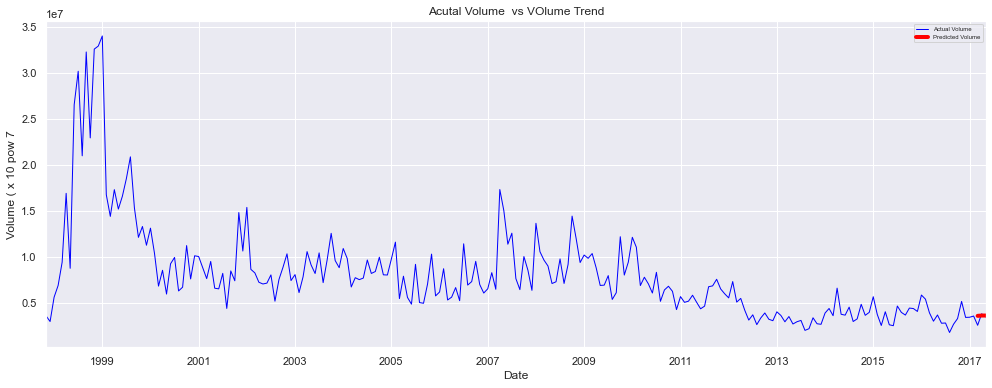

In [51]:
dt_vol['Volume'][6:-6].plot(label='Actual Volume',c='blue')
combined_predict.plot(label='Predicted Volume',linewidth=4, c='red')
plt.xlabel('Date')
plt.ylabel('Volume ( x 10 pow 7')
plt.title('Acutal Volume  vs VOlume Trend')
plt.legend(prop={'size': 6})

In [52]:
df_test['Volume']

Date
2017-03-31    2.544442e+06
2017-04-30    3.794550e+06
2017-05-31    3.457618e+06
Freq: M, Name: Volume, dtype: float64

In [53]:
test = df_test['Volume'].values
pred = combined_predict.values

mae = mean_absolute_error(test, pred)
R2 = r2_score(test, pred)
rmse = np.sqrt(mean_squared_error(test, pred))
print('RMSE: %f' % rmse)
print('R2: %f' % R2)
print('MAE: %f' % mae)

RMSE: 608194.732312
R2: -0.326241
MAE: 454189.293009


## Feed Forward Neural Network

The trend component of the Volume data is used to create a Feed Forward Neural Network by using LSTM algorithm.  The input data is just an array of trend values. To add more features to the input data, each row of the input data is appended with past 12 months of data as input. This is expected to help to create a better prediction model rather than a model dependent on single feature

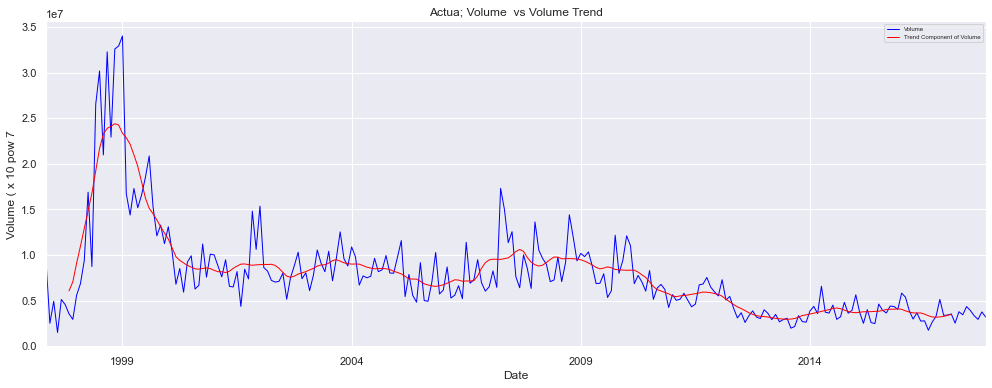

In [54]:
dt_vol['Volume'].plot(c='blue')
df_trend_train.plot(label='Trend Component of Volume',c='red')
plt.xlabel('Date')
plt.ylabel('Volume ( x 10 pow 7')
plt.title('Actua; Volume  vs Volume Trend')
plt.legend(prop={'size': 6})

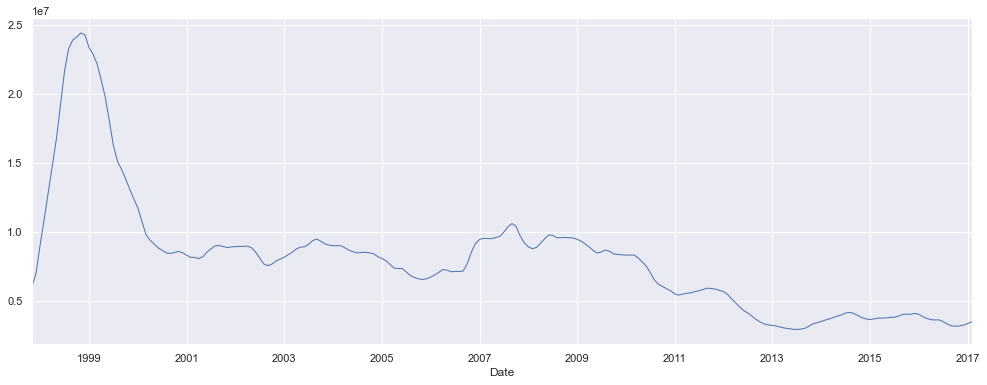

In [55]:
df_trend_train.plot()

In [56]:
df_trend_train

Date
1997-11-30     6081551.0
1997-12-31     7062126.0
1998-01-31     9114239.0
1998-02-28    10976919.0
1998-03-31    12918733.0
                 ...    
2016-10-31     3197801.0
2016-11-30     3222668.0
2016-12-31     3280260.0
2017-01-31     3393711.0
2017-02-28     3507210.0
Freq: M, Name: TREND, Length: 232, dtype: float64

In [57]:
print("Size of X =",len(df_trend_train))

Size of X = 232


In [58]:
data = pd.concat([df_trend_train, 
                 df_trend_train.shift(), 
                 df_trend_train.shift(2),
                 df_trend_train.shift(3),
                 df_trend_train.shift(4)], 
                 axis=1
                 ).dropna()

In [59]:
data

,TREND,TREND,TREND,TREND,TREND
Date,,,,,
1998-03-31,12918733.0,10976919.0,9114239.0,7062126.0,6081551.0
1998-04-30,14814464.0,12918733.0,10976919.0,9114239.0,7062126.0
1998-05-31,16788512.0,14814464.0,12918733.0,10976919.0,9114239.0
1998-06-30,19246280.0,16788512.0,14814464.0,12918733.0,10976919.0
1998-07-31,21678764.0,19246280.0,16788512.0,14814464.0,12918733.0
...,...,...,...,...,...
2016-10-31,3197801.0,3220658.0,3353636.0,3530866.0,3658515.0
2016-11-30,3222668.0,3197801.0,3220658.0,3353636.0,3530866.0
2016-12-31,3280260.0,3222668.0,3197801.0,3220658.0,3353636.0


In [60]:
data_np = np.array(data)

In [61]:
# train test split, we can take last 3 months data points as test set
train, test = data_np[0:-3], data_np[-3:]

# Scale
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

# training data
y_train = train_scaled[:,0]
X_train = train_scaled[:,1:]

# test data
y_test = test_scaled[:,0]
X_test = test_scaled[:,1:]

The X array represents the set of features, Y represent the target value, i.e the trend of the Volume

In [62]:
print("Size of X_train =",len(X_train))

Size of X_train = 225


In [63]:
print("Size of Y =",len(X_test))

Size of Y = 3


A feedforward neural network is created that accepts 1 input layer, 3 hidden layers and one output layer.  The input layer accepts array size 12 inputs and outputs one value as the forecasted value

In [64]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError, MeanAbsolutePercentageError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

lstm_model = Sequential()
lstm_model.add(LSTM(60 , return_sequences = True , input_shape = (X_train.shape[1] , 1))) 
lstm_model.add(LSTM(60 , return_sequences = False))
lstm_model.add(Dense(12))
lstm_model.add(Dense(1))

The model is trained with adam optimizer, mean_square_error as loss function and compiled with batch size of 12 for 50 epochs. The compiled model is used to predict the test data that has same array size as input array. The prediction based on test data represents the trend of the volume. The predicted trend is combined with seasonality and residues of test data in the same manner as above. 

In [65]:
print(len(dt_vol))
print(len(X_test))


247
3


In [66]:
from keras import optimizers
#sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
#sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, clipvalue=1)
#lttm_model.compile(optimizer = sgd , loss = 'mean_squared_error')
lstm_model.compile(optimizer = 'adam' , loss = 'mean_squared_error')

In [67]:
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 4, 60)             14880     
                                                                 
 lstm_1 (LSTM)               (None, 60)                29040     
                                                                 
 dense (Dense)               (None, 12)                732       
                                                                 
 dense_1 (Dense)             (None, 1)                 13        
                                                                 
Total params: 44,665
Trainable params: 44,665
Non-trainable params: 0
_________________________________________________________________


In [68]:
# Predict the volume using LSTM
# predict_trend = lstm_model.predict(X_test)
# predict_trend

In [69]:
y_test

array([0.01479743, 0.02008898, 0.02538277])

In [70]:
# def plot_pred(y_test,predict_trend,period=10):
#     plt.figure()
#     plt.plot(y_test[-period:], "b", label="Actuals")
#     plt.plot(predict_trend[-period:], "r", label="Predictions")
#     plt.title("Actuals vs Predictions")
#     plt.xlabel("Time")
#     plt.legend()
#     plt.show()

# plot_pred(y_test,predict_trend)

In [71]:
lstm_model.fit(X_train , y_train , batch_size = 12 , epochs = 50)

Epoch 1/50
19/19 [==============================] - 3s 3ms/step - loss: 0.0327
Epoch 2/50
19/19 [==============================] - 0s 3ms/step - loss: 0.0073
Epoch 3/50
19/19 [==============================] - 0s 3ms/step - loss: 0.0025
Epoch 4/50
19/19 [==============================] - 0s 3ms/step - loss: 0.0023
Epoch 5/50
19/19 [==============================] - 0s 3ms/step - loss: 0.0022
Epoch 6/50
19/19 [==============================] - 0s 3ms/step - loss: 0.0022
Epoch 7/50
19/19 [==============================] - 0s 3ms/step - loss: 0.0025
Epoch 8/50
19/19 [==============================] - 0s 3ms/step - loss: 0.0023
Epoch 9/50
19/19 [==============================] - 0s 3ms/step - loss: 0.0023
Epoch 10/50
19/19 [==============================] - 0s 3ms/step - loss: 0.0025
Epoch 11/50
19/19 [==============================] - 0s 3ms/step - loss: 0.0022
Epoch 12/50
19/19 [==============================] - 0s 3ms/step - loss: 0.0022
Epoch 13/50
19/19 [==============================

In [72]:
y_pred = lstm_model.predict(X_test)

1/1 [==============================] - 1s 570ms/step


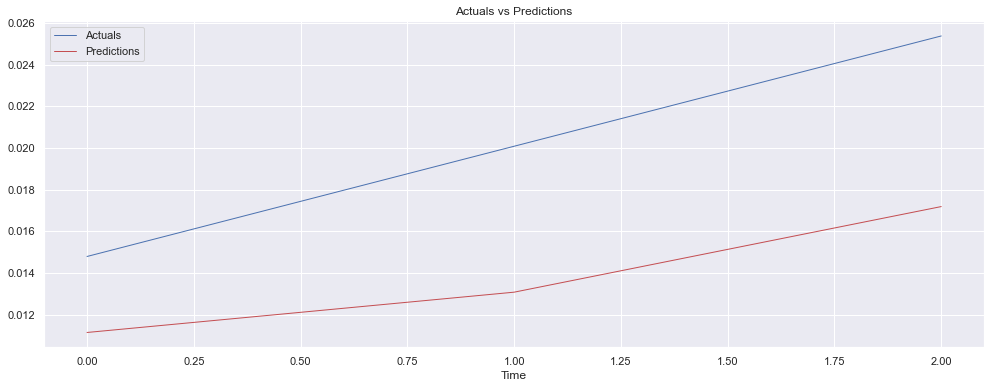

In [73]:
def plot_pred(y_test,y_pred,period=10):
    plt.figure()
    plt.plot(y_test[-period:], "b", label="Actuals")
    plt.plot(y_pred[-period:], "r", label="Predictions")
    plt.title("Actuals vs Predictions")
    plt.xlabel("Time")
    plt.legend()
    plt.show()

plot_pred(y_test,y_pred)

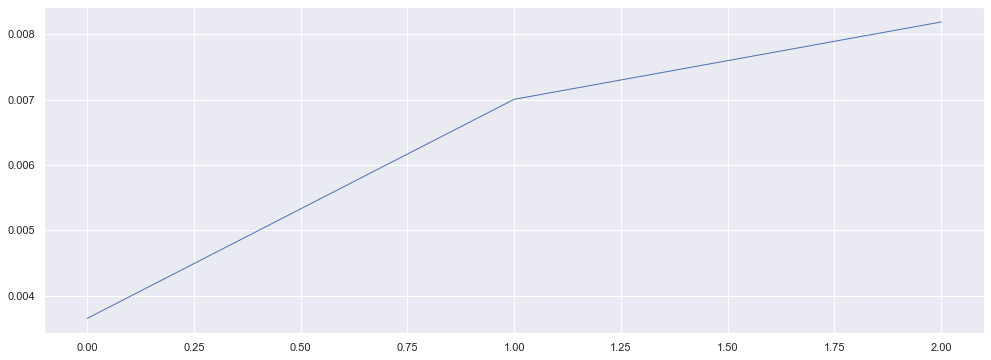

In [74]:
errors = np.squeeze(y_test) - np.squeeze(y_pred)
plt.plot(errors)

In [75]:
def multistep_prediction(H, model, X_pred,residuals=[]):
    # Initialise lists for storing multi-step predictions
    y_pred_multi = []
    X_pred_multi = []

    for t in range(H):
        # get next prediction
        X_pred = np.array(X_pred.reshape(1,len(X_pred)))
        new_y= float(model.predict(X_pred))
        # print("new_y")
        # print(new_y)
    
        # update 
        y_pred_multi.append(float(new_y))
        X_pred_multi.append(list(X_pred[0])) 
        # print("y_pred_multi")
        # print(y_pred_multi)
        # print("X_pred_multi")
        # print(X_pred_multi)
    
        # prepare net input with bootstrapped training residuals
        X_pred = X_pred_multi[t][:-1]
        if len(residuals) == 0:
            X_pred.insert(0,new_y)
        else:
            X_pred.insert(0,(new_y+np.random.choice(residuals)))
        X_pred = np.array(X_pred)
        # print("new X")
        # print(X_pred)
        
    return y_pred_multi, X_pred_multi

1/1 [==============================] - 0s 15ms/step


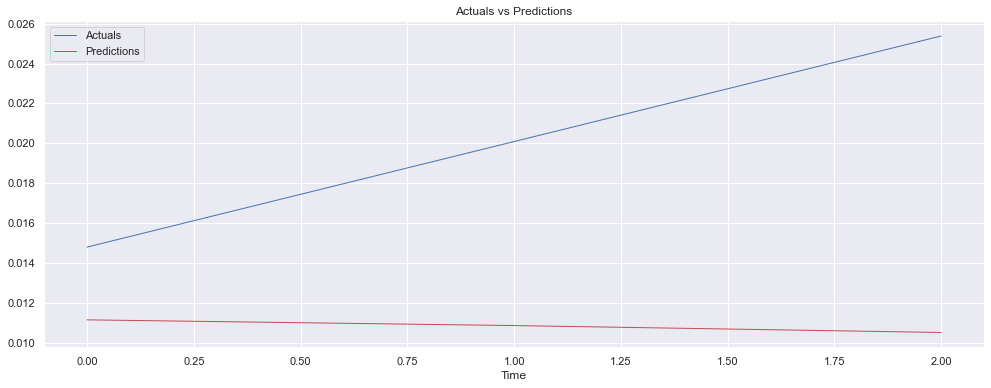

In [76]:
# Prediction horizon
H = 3

X_test_multi = X_test[-H:,:]
y_test_multi = y_test[-H:]
# y_pred_multi = model.predict(X_test_multi)    
# plot_pred(y_test_multi,y_pred_multi)

# Prepare first input to multistep prediction loop
X_pred = X_test_multi[0,:]

# Multistep prediction
y_pred_multi, X_pred_multi = multistep_prediction(H,lstm_model,X_pred)
plot_pred(y_test_multi, y_pred_multi)

In [77]:
df_test['trend_pred'] = y_pred

In [78]:
residuals = np.squeeze(y_train) - np.squeeze(lstm_model.predict(X_train))

8/8 [==============================] - 0s 2ms/step


In [79]:
# Bootstrap iterations
K = 100

# Prepare first input to multistep bootsrtap loop
X_pred = X_test_multi[0,:]
y_pred_bootstrap = []

# Use multistep prediction to generate bootstrap data, 
# List of training residuals to sample from passed in as fourth argument 

for k in range(K):
    y_pred_multi, X_pred_multi = multistep_prediction(H,lstm_model,X_pred,residuals)
    y_pred_bootstrap.append(y_pred_multi)
    # store y predictions

1/1 [==============================] - 0s 16ms/step


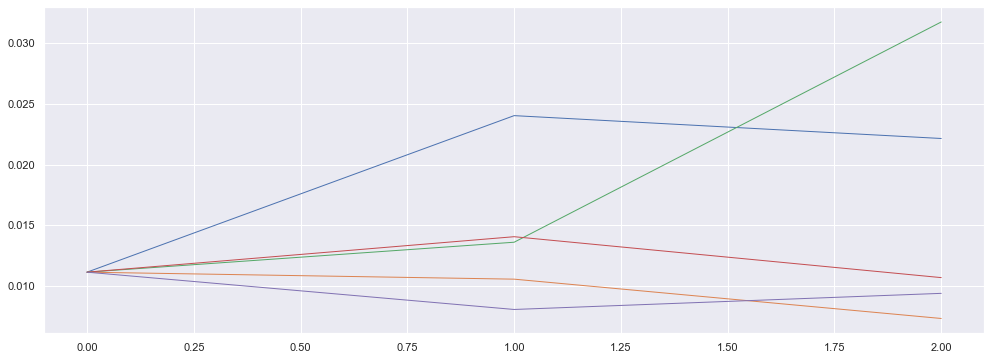

In [80]:
def transposed_2d_list(l):
    return [[row[i] for row in l] for i in range(len(l[0]))]    

plt.plot(transposed_2d_list(y_pred_bootstrap[-5:]))

In [81]:
bootstrap_predictions = pd.DataFrame(index = data.index.values[-H:])

for pctl in range(0,101,10):
    bootstrap_predictions[str(pctl)] = np.percentile(y_pred_bootstrap,pctl,axis=0)

bootstrap_predictions.rename(columns={'50': "median"}, inplace=True)
bootstrap_predictions['actuals'] = y_test[-H:]

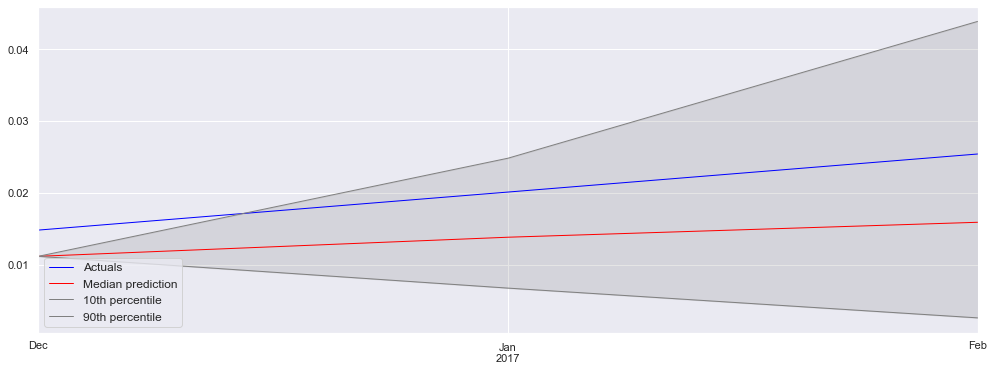

In [82]:
# plot interval with fill
fig, ax_bootstrap = plt.subplots()
bootstrap_predictions['actuals'].plot(color = 'blue', label='Actuals', axes=ax_bootstrap)
bootstrap_predictions['median'].plot(color = 'red',label = 'Median prediction', axes=ax_bootstrap )
bootstrap_predictions['10'].plot(color = 'grey', label = '10th percentile', axes=ax_bootstrap )
bootstrap_predictions['90'].plot(color = 'grey', label = '90th percentile', axes=ax_bootstrap )
plt.legend(loc = 'lower left', fontsize = 12)

x = data.index.values[-H:]
plt.fill_between(x, bootstrap_predictions['10'], bootstrap_predictions['90'], color='grey', alpha=0.2)

Plot Actual Vs Predicted using Feed Forward Newtwork

In [83]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error ,mean_absolute_error, r2_score


mae = mean_absolute_error(y_test, y_pred)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))   
R2 = r2_score(y_test, y_pred)
print('RMSE: %f' % rmse)
print('R2: %f' % R2)
# print('MAPE: %f' % mae)
print('MAE: %f' % mae)

RMSE: 0.006569
R2: -1.310850
MAE: 0.006281
